In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import seaborn as sns
from matplotlib import pyplot
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [47]:
df = pd.read_csv("../Documents/PHS/Statistics for HDS/module assessment/part2/child_cleaned.csv")
df = df.drop("Unnamed: 0",axis=1)
df

,social,motherIQ,alcohol,smoke,birthorder,birthwt,childage,score,disease
0,2,1,1,1,1,3.78,5.00,110,0
1,2,1,1,1,2,3.03,5.17,91,0
2,1,1,3,2,2,2.71,5.08,91,0
3,2,2,1,1,1,2.92,4.92,96,0
4,1,1,2,2,2,3.62,4.92,93,1
...,...,...,...,...,...,...,...,...,...
1842,3,2,2,2,2,3.07,5.00,96,0
1843,1,2,2,1,2,3.87,4.92,90,0
1844,2,2,1,1,3,3.99,5.00,96,0
1845,3,2,1,1,1,4.27,5.00,90,0


In [63]:
def get_dataset(return_X=True, over_sampling = True):
    X = df.to_numpy()[:,:-2]
    y = df["disease"]
    
    if over_sampling:
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X, y)
        return X_resampled, np.array(y_resampled, dtype=int)
    
    return X, np.array(y, dtype=int)
len(get_dataset()[1])

3272

In [51]:
def data_split():
    X, y = get_dataset()
    split_indices = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X, y):
        split_indices.append((train_index, test_index))

    return split_indices

In [56]:
def train_and_test(model_name, svm_kernel='rbf'):
    X, y = get_dataset()
    split_indices = data_split()
    y_pre, y_tru = np.array([]), np.array([])

    for train_indices, test_indices in split_indices:
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        if model_name=='LR':
            model = LogisticRegression(solver='lbfgs', max_iter=10000)
        elif model_name=='KNN':
            model = KNeighborsClassifier()
        elif model_name=='SVM':
            model = SVC(kernel=svm_kernel)
        elif model_name=='XGBoost':
            model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        else:
            print('No matched classifiers')
            return
        
        model.fit(X_train, y_train)

        y_test_pre = model.predict(X_test)
        y_pre = np.concatenate((y_pre, y_test_pre))
        y_tru = np.concatenate((y_tru, y_test))

    return {'pre': y_pre, 'tru': y_tru}


In [38]:
def plot_heatmap(res, model_name):
    print('Model:', model_name)
    classes = [0,1]
    y_pred, y_test = res['pre'].astype(int), res['tru'].astype(int)
    
    vis = confusion_matrix(y_test, y_pred)
    accu = accuracy_score(y_test, y_pred)
    
    #print(classification_report(y_test, y_pred))
    print('Accuracy: %.2f%%' % (accu*100))
    
    pd_vis = pd.DataFrame(vis, columns=classes, index=classes)
    ax = sns.heatmap(pd_vis, cmap="Blues", annot=True, fmt='d')

Model: Multinominal Logistic Regression
Accuracy: 58.37%


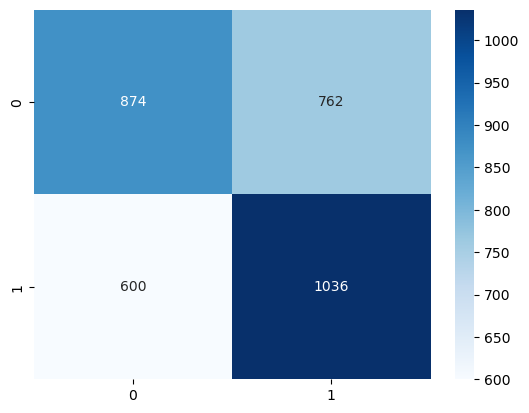

In [64]:
res_lr = train_and_test('LR')
plot_heatmap(res_lr, 'Multinominal Logistic Regression')

Model: XGBoost
Accuracy: 90.31%


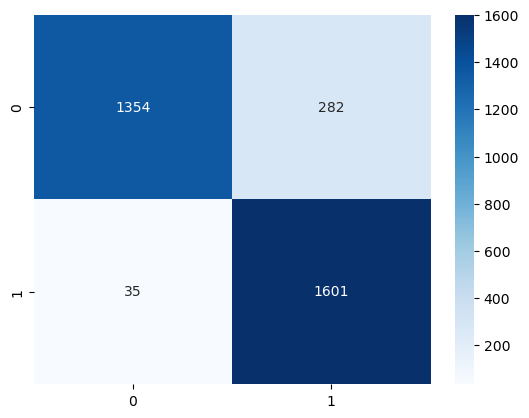

In [58]:
res_xgboost = train_and_test('XGBoost')
plot_heatmap(res_xgboost, 'XGBoost')

Model: KNN
Accuracy: 81.02%


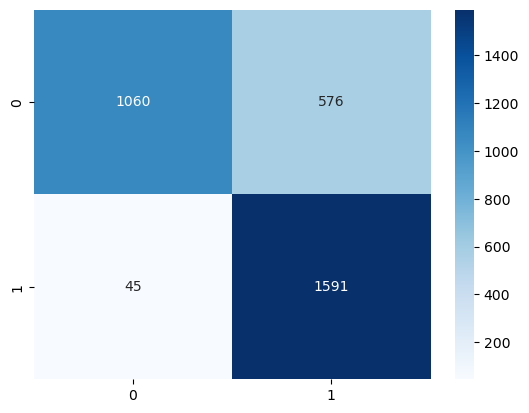

In [59]:
res_knn = train_and_test('KNN')
plot_heatmap(res_knn, 'KNN')

Model: SVM, kernel: rbf
Accuracy: 59.50%


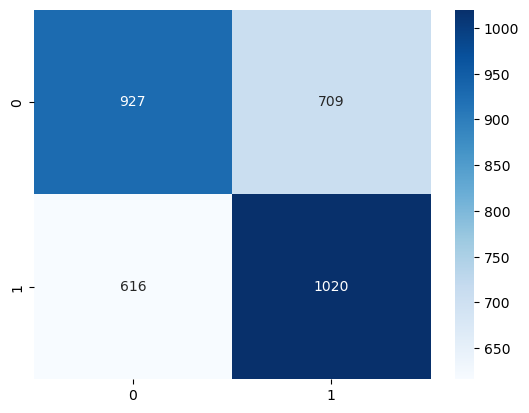

In [60]:
res_svm_rbf = train_and_test('SVM', 'rbf')
plot_heatmap(res_svm_rbf, 'SVM, kernel: rbf')